In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

from IPython.display import display, HTML

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ

    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__R__ = R
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        if w == 0 :
            self.R1.resistance = self.__R * 0.0000001
            self.R2.resistance = self.__R * 0.9999999
        elif w == 1 :
            self.R1.resistance = self.__R * 0.9999999
            self.R2.resistance = self.__R * 0.0000001
        else :
            self.R1.resistance = self.__R * w
            self.R2.resistance = self.__R * (1.0-w)

# construction

The AD/AR contains two envelope circuits and one pulse timer. Both will have a trigger at the end of the envelope or delayed pulse. The end of envelope is not connected to another input, those must be patched. The output of the delayed pulse is connected to the input of the first envelope.

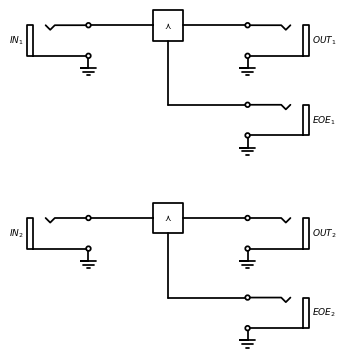

In [3]:
d = schemdraw.Drawing(unit=2.1, inches_per_unit=0.5, lw=1.75, fontsize=9)

for i in range(2) :
    JI4 = d.add(elm.AudioJack(xy=[0, -i*3*d.unit], lftlabel=f'$IN_{i+1}$'))
    d.add(elm.Ground("right", xy=JI4.sleeve))
    d.add(elm.Line( "right", l=d.unit, at=JI4.tip))
    E1 = d.add(dsp.Square(label='$\curlywedge$'))
    d.add(elm.Line( "right", l=d.unit))
    JO1 = d.add(elm.AudioJack("left", flip=True, anchor='tip', rgtlabel=f'$OUT_{i+1}$'))
    d.add(elm.Ground("right", xy=JO1.sleeve))
    d.add(elm.Line("down", xy=E1.S))
    d.add(elm.Line("right", tox=JO1.tip))
    JO2 = d.add(elm.AudioJack("left", flip=True, anchor='tip', rgtlabel=f'$EOE_{i+1}$'))
    d.add(elm.Ground("right", xy=JO2.sleeve))


d.draw()


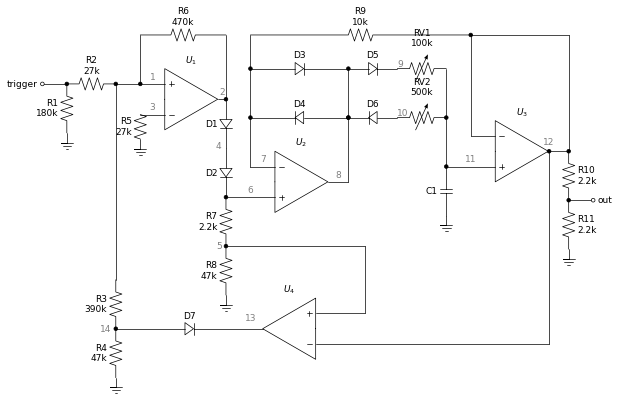

In [4]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += (op1 := elm.Opamp().at([5,0]).flip().label('$U_1$'))
d += elm.Line().left().at(op1.in1).length(d.unit/2).label('3', color='Grey')
d += elm.Resistor().down().length(d.unit/2).label('R5\n27k')
d += elm.Ground()

d += elm.Line().length(d.unit/2).left().at(op1.in2).label('1', color='Grey')
d += elm.Dot()
d.push()
d += elm.Line().length(d.unit/2).left()
d += ( Dot0 := elm.Dot())
d += elm.Resistor().label('R2\n27k')
d += elm.Dot()
d.push()
d += elm.Resistor().label('R1\n180k').down()
d += elm.Ground()
d.pop()
d += elm.Line().length(d.unit/2).left()
d += elm.Dot(open=True).label('trigger', loc="lft")
d.pop()
d += elm.Line().up().length(d.unit)
d += ( R3 := elm.Resistor().right().length(d.unit*1.75).label('R6\n470k'))
d += elm.Line().down().toy(op1.out)
d += elm.Dot()
d.push()
d += elm.Line().left().tox(op1.out).label('2', color='Grey')

d.pop()
d += elm.Diode().down().label('D1')
d += elm.Diode().down().label('D2').label('4', loc='start', color='Grey', ofst=(-.1, -0.2) )
d += elm.Dot()
d.push()

d += elm.Resistor().down().label('R7\n2.2k')
d += ( Dot1 := elm.Dot()).label('5', loc='left', color='Grey')
d += elm.Resistor().down().label('R8\n47k')
d += elm.Ground()

d.pop()
d += elm.Line().right().label('6', color='Grey')
d += (op2 := elm.Opamp().anchor('in2').label('$U_2$'))

d += elm.Line().at(op2.in1).left().length(d.unit/2).label('7', color='Grey')
d += elm.Line().up()
d += elm.Dot()
d.push()
d += elm.Diode().right().reverse().length(d.unit*2).label('D4')
d += elm.Dot()

d += elm.Dot()
d += elm.Diode().reverse().label('D6').label('10', loc='end', color='Grey', ofst=(0, .2) )
d += elm.ResistorVarIEEE().label('RV2\n500k')
d += elm.Dot()

d.pop()
d += elm.Line().up()
d += ( Dot2 := elm.Dot())
d += elm.Diode().right().length(d.unit*2).label('D3')
d += elm.Dot()
d.push()
d += elm.Diode().label('D5').label('9', loc='end', color='Grey', ofst=(0, .2) )
d += elm.ResistorVarIEEE().label('RV1\n100k')

d += elm.Line().down().length(d.unit*2)
d += elm.Dot()
d.push()
d += elm.Capacitor().label('C1')
d += elm.Ground()

d.pop()
d += elm.Line().right().length(d.unit).label('11', color='Grey')
d += (op3 := elm.Opamp().anchor('in2').label('$U_3$'))

d.pop()
d += elm.Line().down().toy(op2.out)
d += elm.Line().left().tox(op2.out).label('8', color='Grey')

d += elm.Line().at(op3.in1).length(d.unit/2).left()

d += elm.Line().up().toy(R3.end)
d += elm.Dot()
d.push()
d += elm.Resistor().left().label('R9\n10k').tox(Dot2.end)
d += elm.Line().down().toy(Dot2.end)

d.pop()
d += elm.Line().right().length(d.unit*2)
d += elm.Line().down().toy(op3.out)
d += elm.Dot()
d.push()

d += ( D3 := elm.Line().left().length(d.unit*0.4))
d += elm.Dot().label('12', color='Grey')
d += elm.Line().left().tox(op3.out)

d.pop()
d += elm.Resistor().down().label('R10\n2.2k', loc='bottom')
d += elm.Dot()
d.push()
d += elm.Resistor().down().label('R11\n2.2k', loc='bottom')
d += elm.Ground()

d.pop()
d += elm.Line().right().length(d.unit/2)
d += elm.Dot(open=True).label('out', loc='right')

d += elm.Line().at(Dot0.end).down().length(d.unit*4)
d += elm.Resistor().label('R3\n390k')
d += elm.Dot().label('14', loc='left', color='Grey')
d.push()
d += elm.Resistor().label('R4\n47k')
d += elm.Ground()

d.pop()
d += elm.Diode().right().length(d.unit*3).label('D7').label('13', color='Grey', ofst=(2.5, 0))
#d += elm.Line().right().length(d.unit*3).label('14', color='Grey')
d += (op4 := elm.Opamp().anchor('out').label('$U_4$')).left()

d += elm.Line().right().at(op4.in1).tox(D3.end)
d += elm.Line().up().toy(D3.end)

d += elm.Line().right().at(op4.in2)
d += elm.Line().up().toy(Dot1.end)
d += elm.Line().left().tox(Dot1.end)

d.draw()




In [5]:
ar_circuit = Circuit('ad_ar')
ar_circuit.include(spice_library['TL072'])
ar_circuit.include(spice_library['D1N4148'])
ar_circuit.include(spice_library['CD4081B'])

ar_circuit.V('1', '+15V', ar_circuit.gnd, 'DC 15')
ar_circuit.V('2', '-15V', ar_circuit.gnd, 'DC -15')
ar_circuit.V('3', 'TRIGGER', ar_circuit.gnd, 'DC 0 AC 0 PULSE(0 5 20m 0m 0m 60m 200m)')
ar_circuit.V('4', 'REF', ar_circuit.gnd, 'DC 0.5')
#ar_circuit.V('3', 'TRIGGER', ar_circuit.gnd, 'DC 0 AC 0 PULSE(0 5 20m 10m 0m 10m 75m)')

#the opamps
#                     NON-INVERTING INPUT
#                     |           INVERTING INPUT
#                     |           |             POSITIVE POWER SUPPLY
#                     |           |             |       NEGATIVE POWER SUPPLY
#                     |           |             |       |       OUTPUT
#                     |           |             |       |       |
ar_circuit.X(1, 'TL072', '1',        '3',          '+15V', '-15V', '2')
ar_circuit.X(2, 'TL072', '6',        '7',          '+15V', '-15V', '8')
ar_circuit.X(3, 'TL072', '11',       '12',         '+15V', '-15V', '12')
ar_circuit.X(4, 'TL072', '5',        '12',         '+15V', '-15V', '13')
ar_circuit.X(5, 'TL072', 'REF',      '12',         '+15V', '-15V', '16')
ar_circuit.X(6, 'TL072', ar_circuit.gnd,      '5', '+15V', '-15V', '17')
ar_circuit.X(7, 'CD4081B', 'loop',   '16', '17', '+15V', ar_circuit.gnd)

#CV voltage divider
ar_circuit.R(1, 'TRIGGER', ar_circuit.gnd, 180@u_kΩ)
ar_circuit.R(2, 'TRIGGER', '1', 27@u_kΩ)
ar_circuit.R(3, '1', '14', 390@u_kΩ)
ar_circuit.R(4, '14', ar_circuit.gnd, 47@u_kΩ)
ar_circuit.R(5, '3', ar_circuit.gnd, 0) #27@u_kΩ)
ar_circuit.R(6, '1', '2', 470@u_kΩ)
ar_circuit.R(7, '6', '5', 2.2@u_kΩ)
ar_circuit.R(8, '5', ar_circuit.gnd, 47@u_kΩ)
ar_circuit.R(9, '7', '12', 10@u_kΩ)
ar_circuit.R(10, '12', 'out', 2.2@u_kΩ)
ar_circuit.R(11, 'out', ar_circuit.gnd, 2.2@u_kΩ)

ar_circuit.D('1', '2', '4', model='D1N4148')
ar_circuit.D('2', '4', '6', model='D1N4148')
ar_circuit.D('3', '7', '8', model='D1N4148')
ar_circuit.D('4', '8', '7', model='D1N4148')
ar_circuit.D('5', '8', '9', model='D1N4148')
ar_circuit.D('6', '10', '8', model='D1N4148')
ar_circuit.D('7', '14', '13', model='D1N4148')
ar_circuit.D('8', ar_circuit.gnd, '17', model='D1N4148')

for c in ( VoltageDivider(R=100@u_kΩ, w=0.8, name='POT1'), 
           VoltageDivider(R=500@u_kΩ, w=0.99, name='POT2') ) :
    ar_circuit.subcircuit(c)
    
ar_circuit.X('RV1', 'POT1', '9', '9', '11')
ar_circuit.X('RV2', 'POT2', '10', '10', '11')
    
ar_circuit.C(1, '11', ar_circuit.gnd, 2.2@u_uF)

ar_simulator = ar_circuit.simulator(temperature=25, nominal_temperature=25)
#ar_simulator.options('INTERP')
#ar_simulator.initial_condition("Net-_C5-Pad1_"=0.0)
ar_analysis = ar_simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=400@u_ms)


In [6]:
print(ar_circuit)

.title ad_ar
.include /github/workspace/lib/spice/opamp/TL072.lib
.include /github/workspace/lib/spice/diode/1N4148.mod
.include /github/workspace/lib/spice/cmos/CD4081B.lib
.subckt POT1 n1 n2 n3
R1 n1 n2 80.0kOhm
R2 n2 n3 19.999999999999996kOhm
.ends POT1

.subckt POT2 n1 n2 n3
R1 n1 n2 495.0kOhm
R2 n2 n3 5.000000000000004kOhm
.ends POT2
V1 +15V 0 DC 15
V2 -15V 0 DC -15
V3 TRIGGER 0 DC 0 AC 0 PULSE(0 5 20m 0m 0m 60m 200m)
V4 REF 0 DC 0.5
X1 1 3 +15V -15V 2 TL072
X2 6 7 +15V -15V 8 TL072
X3 11 12 +15V -15V 12 TL072
X4 5 12 +15V -15V 13 TL072
X5 REF 12 +15V -15V 16 TL072
X6 0 5 +15V -15V 17 TL072
X7 loop 16 17 +15V 0 CD4081B
R1 TRIGGER 0 180kOhm
R2 TRIGGER 1 27kOhm
R3 1 14 390kOhm
R4 14 0 47kOhm
R5 3 0 0
R6 1 2 470kOhm
R7 6 5 2.2kOhm
R8 5 0 47kOhm
R9 7 12 10kOhm
R10 12 out 2.2kOhm
R11 out 0 2.2kOhm
D1 2 4 D1N4148
D2 4 6 D1N4148
D3 7 8 D1N4148
D4 8 7 D1N4148
D5 8 9 D1N4148
D6 10 8 D1N4148
D7 14 13 D1N4148
D8 0 17 D1N4148
XRV1 9 9 11 POT1
XRV2 10 10 11 POT2
C1 11 0 2.2uF



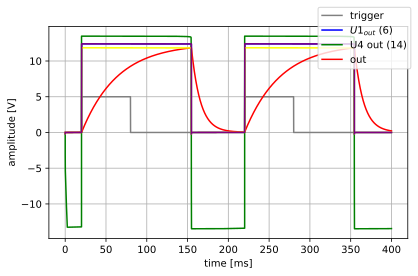

In [7]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(u_ms(ar_analysis['TRIGGER'].abscissa), ar_analysis['TRIGGER'], color='Grey')
ax1_buffer.plot(u_ms(ar_analysis['6'].abscissa), ar_analysis['6'], color='Blue')
ax1_buffer.plot(u_ms(ar_analysis['13'].abscissa), ar_analysis['13'], color='Green')
ax1_buffer.plot(u_ms(ar_analysis['12'].abscissa), ar_analysis['12'], color='Red')
#ax1_buffer.plot(u_ms(ar_analysis['2'].abscissa), ar_analysis['2'], color='Orange')
ax1_buffer.plot(u_ms(ar_analysis['5'].abscissa), ar_analysis['5'], color='Yellow')
ax1_buffer.plot(u_ms(ar_analysis['6'].abscissa), ar_analysis['6'], color='Purple')
#ax1_buffer.plot(u_ms(ar_analysis['loop'].abscissa), ar_analysis['loop'], color='Orange')

ax1_buffer.legend(('trigger', '$U1_{out}$ (6)', 'U4 out (14)', 'out'), loc=(0.75,0.8))

plt.grid()
plt.tight_layout()
plt.show()

In this circuit U1 is a latch. It goes high when there is an input signal. 

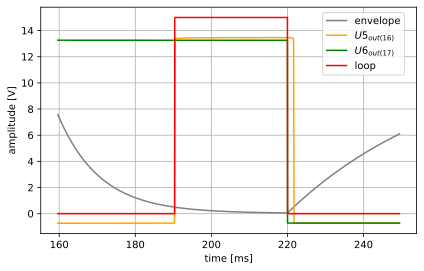

In [8]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(u_ms(ar_analysis['12'].abscissa[160000:250000]), ar_analysis['12'][160000:250000], color='Grey')
ax1_buffer.plot(u_ms(ar_analysis['16'].abscissa[160000:250000]), ar_analysis['16'][160000:250000], color='Orange')
ax1_buffer.plot(u_ms(ar_analysis['17'].abscissa[160000:250000]), ar_analysis['17'][160000:250000], color='Green')
ax1_buffer.plot(u_ms(ar_analysis['loop'].abscissa[160000:250000]), ar_analysis['loop'][160000:250000], color='Red')

ax1_buffer.legend(('envelope', '$U5_{out(16)}$', '$U6_{out(17)}$', 'loop'), loc=(0.75,0.7))

plt.grid()
plt.tight_layout()
plt.show()

For the end of envelope trigger we use another comperator. This comperator will trigger at about 0.6V. The trigger starts on he falling edge and ends on the rising edge at 0.6 V again (Orange). An AND gate will limit the trigger to the falling gate. One input is the output of the comperator the other the inverted output of the latch.

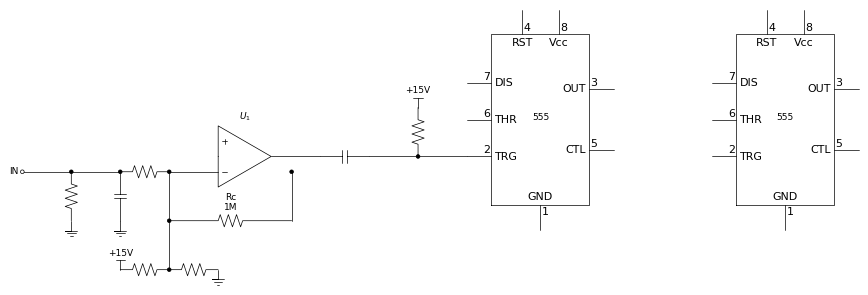

In [9]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += ( U2 := elm.Ic555().at([10,0]))
d += ( U3 := elm.Ic555().at([20,0]))

d += elm.Line().left().at(U2.TRG)
d += elm.Dot()
d.push()
d += elm.Line()
d += elm.Capacitor()
d += elm.Line()
d += (U1 := elm.Opamp().reverse().anchor('out').label('$U_1$'))

d.pop()
d += elm.Resistor().up()
d += elm.Vdd().label('+15V')

d += elm.Line().left().at(U1.in1)
d += elm.Dot()
d.push()
d += elm.Resistor().left()
d += elm.Dot()
d.push()
d += elm.Line()
d += elm.Dot()
d.push()
d += elm.Line()
d += elm.Dot(open=True).label('IN', loc='left')

d.pop()
d += elm.Resistor().down()
d += elm.Ground()

d.pop()
d += elm.Capacitor().down()
d += elm.Ground()


d.pop()
d += elm.Line().down()
d += elm.Dot()
d.push()
d += elm.Resistor().right().length(d.unit*2.5).label('Rc\n1M')
d += elm.Line().up()
d += elm.Dot()

d.pop()
d += elm.Line().down()
d += elm.Dot()
d.push()

d += elm.Resistor().left()
d += elm.Vdd().label('+15V')
d.pop() 
d += elm.Resistor().right()
d += elm.Ground()




d.draw()
